In [1]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

path = '/data/examples/flower_classification/'
#path = 'D:\\AI\\where_am_i\\'

#TransferLearning開關
isTransferLearning = True

#input img size, 根據base_model調整圖片size
resize = (224, 224)

#output labels
num_classes = 5


Using TensorFlow backend.


In [2]:

# load model from file
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'DenseNet121.h5'
model_path = os.path.join(save_dir, model_name)
print('load ',model_path)

model = load_model(model_path)


load  /home/jovyan/murphy/midexam/saved_models/DenseNet121.h5


In [3]:

# make a label map
df = pd.read_csv(path + 'mapping.csv', header='infer')
print(df)

df['class']=df['class'].astype(np.int32)
yMap = dict(zip(df['dirs'], df['class']))
yRMap = dict(zip(df['class'], df['dirs']))
print(len(yMap), yMap)

        dirs  class
0      daisy      0
1  dandelion      1
2       rose      2
3  sunflower      3
4      tulip      4
5 {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [4]:

def showImg(imgNumData):
    img = np.copy(imgNumData) #不copy會重覆改到x_test的內容
    img[:,:,0] = (img[:,:,0] / 0.017) + 103.94
    img[:,:,1] = (img[:,:,1] / 0.017) + 116.78
    img[:,:,2] = (img[:,:,2] / 0.017) + 123.68
    img = img.astype(np.int32)
    img = img[:,:,::-1]  # RGB to BGR    
    
    plt.figure()
    plt.imshow(img)

In [5]:
def getImgData(filePath, showLog=False):
    file = np.array(cv2.resize(cv2.imread(filePath), resize).astype(np.float32))
    if showLog:
        print('image shape', file.shape)
        print('first pixel color', file[0][0])
        
    if isTransferLearning:
        #normalize 
        #BGR mean values [103.94,116.78,123.68] are subtracted
        #scale: 0.017 is used, instead of the original std values for image preprocessing
        file[:,:,0] = (file[:,:,0] - 103.94) * 0.017
        file[:,:,1] = (file[:,:,1] - 116.78) * 0.017
        file[:,:,2] = (file[:,:,2] - 123.68) * 0.017
    else:
        file /= 255.
    
    if showLog:
        print('normalize color', file[0][0])
        
    return file

In [6]:
# make a test data table
import os
import pandas as pd

testList = []
for dirname, dirnames, filenames in os.walk(path+'test'):    
    for filename in filenames:
        row = []
        row.append(filename.replace('.jpg',''))
        row.append(os.path.join(dirname, filename))
        testList.append(row)
        
testDf = pd.DataFrame(testList, columns=['id','path'])        
  
print(testDf.shape, testDf.iloc[0,0], testDf.iloc[0,1])


(500, 2) 100080576_f52e8ee070_n /data/examples/flower_classification/test/100080576_f52e8ee070_n.jpg


In [7]:
testDf.head()

,id,path
0,100080576_f52e8ee070_n,/data/examples/flower_classification/test/1000...
1,1008566138_6927679c8a,/data/examples/flower_classification/test/1008...
2,100930342_92e8746431_n,/data/examples/flower_classification/test/1009...
3,1022552002_2b93faf9e7_n,/data/examples/flower_classification/test/1022...
4,1022552036_67d33d5bd8_n,/data/examples/flower_classification/test/1022...


image shape (224, 224, 3)
first pixel color [ 0.  0.  0.]
normalize color [-1.76698017 -1.98526013 -2.10256004]
{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}
predict %:  [[  9.99983430e-01   1.36543792e-06   3.29532963e-06   1.11017525e-05
    8.70406836e-07]]
[0]
predict result:  daisy


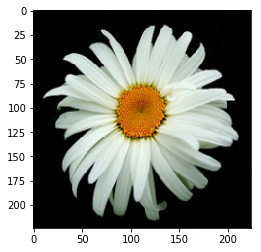

In [8]:
filePath = testDf[testDf['id'] == '172882635_4cc7b86731_m']['path'].item()
imgData = getImgData(filePath, True)
showImg(imgData)

newShape = (1,) + imgData.shape #增加dimention符合predict格式
imgDataTable = imgData.reshape(newShape)


y_val_pred_prob = model.predict(imgDataTable)
print(yRMap)
print('predict %: ',y_val_pred_prob)

y_val_label = y_val_pred_prob.argmax(axis=-1)
print(y_val_label)

print('predict result: ',yRMap[y_val_label[0]])



In [9]:
#圖檔變數值資料
def getXData(dataFrame):
    re = []
    X = np.array([getImgData(file) for file in dataFrame['path']])
    print('X.shape', X.shape)
    return X

In [10]:
from keras import backend as K

trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648


In [11]:
#model.summary()

<h2>prepare data!</h2>

In [12]:
import os
import pandas as pd

#make a image table
trainList = []
for dirname, dirnames, filenames in os.walk(path+'train'):    
    for filename in filenames:
        folderName = os.path.split(dirname)[-1]
        #print(os.path.join(dirname, filename), folderName)        
        row = []
        row.append(yMap[folderName])
        row.append(folderName)
        row.append(filename)
        row.append(os.path.join(dirname, filename))
        trainList.append(row)        
        
trainDf = pd.DataFrame(trainList, columns=['label','folder','file','path'])          
print(trainDf.shape)
trainDf.head()

(3823, 4)


,label,folder,file,path
0,0,daisy,10140303196_b88d3d6cec.jpg,/data/examples/flower_classification/train/dai...
1,0,daisy,10172379554_b296050f82_n.jpg,/data/examples/flower_classification/train/dai...
2,0,daisy,10172567486_2748826a8b.jpg,/data/examples/flower_classification/train/dai...
3,0,daisy,10172636503_21bededa75_n.jpg,/data/examples/flower_classification/train/dai...
4,0,daisy,10300722094_28fa978807_n.jpg,/data/examples/flower_classification/train/dai...


In [13]:
import keras

#圖片變數值資料
X = getXData(trainDf)

#one hot encoding Y
label = keras.utils.to_categorical(trainDf['label'], num_classes)

print(label.shape)
print(label[0])

X.shape (3823, 224, 224, 3)
(3823, 5)
[ 1.  0.  0.  0.  0.]


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, label, test_size=0.2, random_state=42) #default就會shuffle, 不用random_state=42

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
print(x_train[0][0][0])
print(y_train[0:5])
print(x_train[0].shape)

(3058, 224, 224, 3) (3058, 5) (765, 224, 224, 3) (765, 5)
[-1.74998009 -1.61126006 -1.69456005]
[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]
(224, 224, 3)


<h2>load model from file!</h2>

In [15]:
y_val_pred_prob = model.predict(x_test)
print(y_val_pred_prob.shape)
y_val_label = y_val_pred_prob.argmax(axis=-1)
y_test_label = y_test.argmax(axis=-1)

labelDf = pd.DataFrame({'label':y_test_label, 'predict':y_val_label})
print(labelDf.shape)

#
crosstab = pd.crosstab(y_test_label, 
            y_val_label)
crosstab

(765, 5)
(765, 2)


col_0,0,1,2,3,4
row_0,,,,,
0,134,6,3,4,3
1,2,185,0,1,2
2,1,2,114,0,8
3,4,0,0,133,3
4,0,1,6,1,152


In [16]:
score = model.evaluate(x_test, y_test, batch_size=128)
score

765/765 [==============================] - 4s 6ms/step


[0.18286555251654457, 0.93856209508733812]

In [17]:
newCC = []
for cc in crosstab.columns:
    vv = str(cc)+'_'+str(yRMap[cc])    
    newCC.append(vv)
    
crosstab.columns = newCC
crosstab.index = newCC



In [18]:
crosstab

,0_daisy,1_dandelion,2_rose,3_sunflower,4_tulip
0_daisy,134,6,3,4,3
1_dandelion,2,185,0,1,2
2_rose,1,2,114,0,8
3_sunflower,4,0,0,133,3
4_tulip,0,1,6,1,152


actual: tulip 
predict: tulip


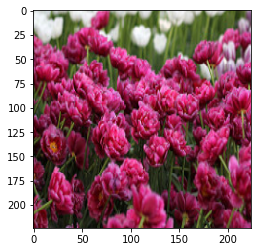

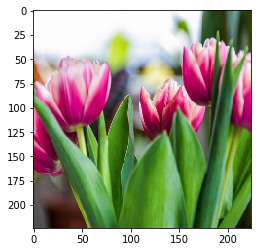

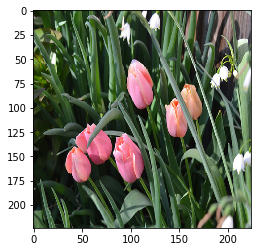

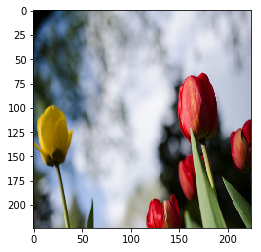

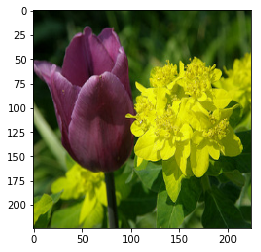

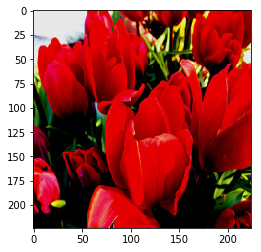

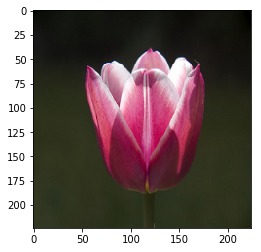

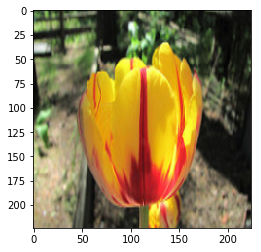

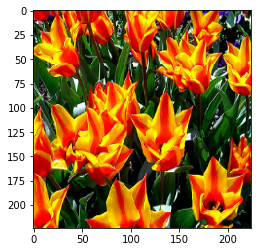

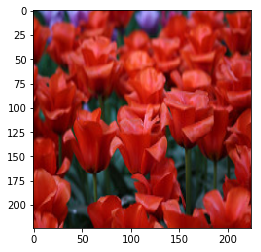

In [24]:
actualIndex, predictIndex = 4,4

print('actual:',yRMap[actualIndex], '\npredict:',yRMap[predictIndex])

ngDf = labelDf[(labelDf.label == actualIndex) & (labelDf.predict == predictIndex)]
ngDf

#
maxCnt = 0
for ii in ngDf.index:
    showImg(x_test[ii])
    maxCnt = maxCnt+1
    if maxCnt >= 10:
        break
